In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.7.0


In [2]:
# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Get the data
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv

--2022-02-02 08:51:51--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2302 (2.2K) [text/plain]
Saving to: ‘moore.csv’

moore.csv           100%[===================>]   2.25K  --.-KB/s    in 0s      

2022-02-02 08:51:51 (19.3 MB/s) - ‘moore.csv’ saved [2302/2302]



In [4]:
# Load in the data
data = pd.read_csv('moore.csv', header=None).values
X = data[:,0].reshape(-1, 1) # make it a 2-D array of size N x D where D = 1
Y = data[:,1]

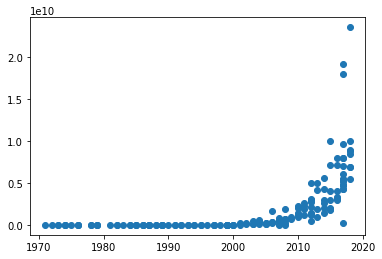

In [5]:
# Plot the data - it is exponential!
plt.scatter(X, Y)

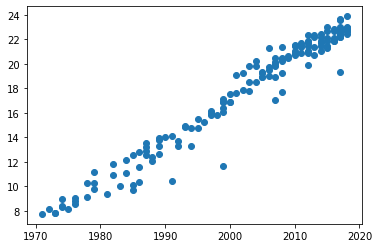

In [6]:
# Since we want a linear model, let's take the log
Y = np.log(Y)
plt.scatter(X, Y)
# that's better

In [7]:
# Let's also center the X data so the values are not too large
# We could scale it too but then we'd have to reverse the transformation later
X = X - X.mean()


In [8]:
# Now create our Tensorflow model
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(0.001, 0.9), loss='mse')
# model.compile(optimizer='adam', loss='mse')


# learning rate scheduler
def schedule(epoch, lr):
  if epoch >= 50:
    return 0.0001
  return 0.001
 

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)


# Train the model
r = model.fit(X, Y, epochs=200, callbacks=[scheduler])

Epoch 1/200
6/6 [==============================] - 1s 3ms/step - loss: 357.0838 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 357.1171 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 4ms/step - loss: 253.7246 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 4ms/step - loss: 214.5567 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 171.5520 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 206.5207 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 161.8114 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - 0s 3ms/step - loss: 116.9164 - lr: 0.0010
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 70.6091 - lr: 0.0010
Epoch 10/200
6/6 [==============================] - 0s 3ms/step - loss: 50.8363 - lr: 0.0010
Epoch 11/200
6/6 [==============================] - 0s 3ms/step - loss:

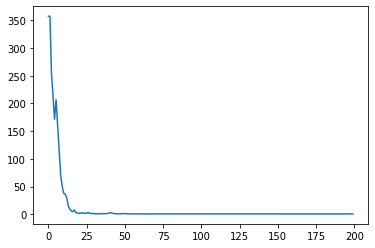

In [9]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')

In [10]:
# Get the slope of the line
# The slope of the line is related to the doubling rate of transistor count
print(model.layers) # Note: there is only 1 layer, the "Input" layer doesn't count
print(model.layers[0].get_weights())

[array([[0.34570196]], dtype=float32), array([17.76654], dtype=float32)]


In [11]:
# The slope of the line is:
a = model.layers[0].get_weights()[0][0,0]

Our original model for exponential growth is:

$$ C = A_0 r^t $$

Where $ C $ is transistor the count and $ t $ is the year.

$ r $ is the rate of growth. For example, when $ t $ goes from 1 to 2, $ C $ increases by a factor of $ r $. When $ t $ goes from 2 to 3, $ C $ increases by a factor of $ r $ again.

When we take the log of both sides, we get:

$$ \log C = \log r * t + \log A_0 $$

This is our linear equation:

$$ \hat{y} = ax + b $$

Where:

$$ \hat{y} = \log C $$
$$ a = \log r $$
$$ x = t $$
$$ b = \log A_0 $$

We are interested in $ r $, because that's the rate of growth. Given our regression weights, we know that:

$$ a = 0.34188038 $$

so that:

$$ r = e^{0.34188038} = 1.4076 $$

To find the time it takes for transistor count to double, we simply need to find the amount of time it takes for $ C $ to increase to $ 2C $.

Let's call the original starting time $ t $, to correspond with the initial transistor count $ C $.

Let's call the end time $ t' $, to correspond with the final transistor count $ 2C $.

Then we also have:

$$ 2C = A_0 r ^ {t'} $$

Combine this with our original equation:

$$ C = A_0 r^t $$

We get (by dividing the 2 equations):

$$ 2C/C = (A_0 r ^ {t'}) / A_0 r^t $$

Which simplifies to:

$$ 2 = r^{(t' - t)} $$

Solve for $ t' - t $:

$$ t' - t = \frac{\log 2}{\log r} = \frac{\log2}{a}$$


Important note! We haven't specified what the starting time $ t $ actually is, and we don't have to since we just proved that this holds for any $ t $.

In [12]:
print("Time to double:", np.log(2) / a)

Time to double: 2.0050426532942676


In [13]:
# If you know the analytical solution
X = np.array(X).flatten()
Y = np.array(Y)
denominator = X.dot(X) - X.mean() * X.sum()
a = ( X.dot(Y) - Y.mean()*X.sum() ) / denominator
b = ( Y.mean() * X.dot(X) - X.mean() * X.dot(Y) ) / denominator
print(a, b)
print("Time to double:", np.log(2) / a)

0.341682487387313 17.764939393631764
Time to double: 2.0286295205239204


# Part 2: Making Predictions

This goes with the lecture "Making Predictions"

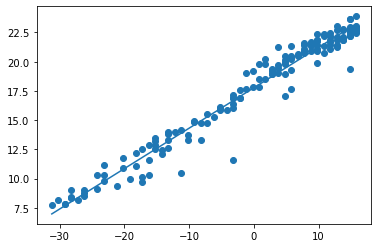

In [14]:
# Make sure the line fits our data
Yhat = model.predict(X).flatten()
plt.scatter(X, Y)
plt.plot(X, Yhat)

In [15]:
# Manual calculation

# Get the weights
w, b = model.layers[0].get_weights()

# Reshape X because we flattened it again earlier
X = X.reshape(-1, 1)

# (N x 1) x (1 x 1) + (1) --> (N x 1)
Yhat2 = (X.dot(w) + b).flatten()

# Don't use == for floating points
np.allclose(Yhat, Yhat2)

True